In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools


In [ ]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', d_color, '#ffa30e', '#f43131', '#2ca02c']

In [ ]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [ ]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [ ]:
movies

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [ ]:
ratings

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


In [ ]:
credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [ ]:
tmdb_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [ ]:
df_movies = movies[movies.Name.isin(credits.title)]
df_movies_2000 = df_movies[df_movies['Year'] >= 2000]
df_movies_2000

,Movie_ID,Year,Name
29,30,2003,Something's Gotta Give
88,89,2000,Chain of Command
147,148,2001,Sweet November
166,167,2004,The Chorus
180,181,2004,The Last Shot
...,...,...,...
17696,17697,2004,New York Minute
17702,17703,2003,Hulk
17706,17707,2004,Latter Days
17742,17743,2003,Better Luck Tomorrow


In [ ]:
df_ratings = ratings[ratings.Movie_ID.isin(df_movies.Movie_ID)]
df_ratings_2000 = ratings[ratings.Movie_ID.isin(df_movies_2000.Movie_ID)]
df_ratings_2000

,User_ID,Rating,Movie_ID
63663,2473170,5,30
63664,900816,3,30
63665,1990901,4,30
63666,1402412,4,30
63667,1601783,3,30
...,...,...,...
17324875,15737,2,4492
17324876,502274,2,4492
17324877,1326640,3,4492
17324878,633738,3,4492


In [ ]:
df_movies_ids = df_movies['Movie_ID'].values
df_credits = credits[credits['movie_id'].isin(df_movies_ids)]
df_credits

,movie_id,title,cast,crew
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
17,1865,Pirates of the Caribbean: On Stranger Tides,"[{""cast_id"": 15, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""566b4f54c3a3683f56005151"", ""de..."
30,558,Spider-Man 2,"[{""cast_id"": 33, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f8015039"", ""de..."
32,12155,Alice in Wonderland,"[{""cast_id"": 7, ""character"": ""Alice Kingsleigh...","[{""credit_id"": ""52fe44c09251416c7503fbc3"", ""de..."
68,1726,Iron Man,"[{""cast_id"": 19, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""52fe4311c3a36847f8037f21"", ""de..."
...,...,...,...,...
4454,11446,Welcome to the Dollhouse,"[{""cast_id"": 1, ""character"": ""Dawn Wiener"", ""c...","[{""credit_id"": ""52fe44419251416c7502e401"", ""de..."
4517,14358,Mad Hot Ballroom,[],"[{""credit_id"": ""52fe45ea9251416c75066cd9"", ""de..."
4726,9821,The Mighty,"[{""cast_id"": 1, ""character"": ""Gwen Dillon"", ""c...","[{""credit_id"": ""52fe4534c3a36847f80c1f2d"", ""de..."
4738,473,Pi,"[{""cast_id"": 5, ""character"": ""Maximillian Cohe...","[{""credit_id"": ""52fe4247c3a36847f8011f69"", ""de..."


---
# **Actor collaboration Network**
---
- Nodes: Actors/actresses
- Edges: Weighted based on how many movies a pair of actors have been starring in together.

In [ ]:
credits_cast = credits['cast'].apply(json.loads)
print(credits_cast)

# Actor Collaboration Network
G_actor = nx.Graph()
for i, row in credits.iterrows():
    for actor in credits_cast[i]: # Node for each actor
        G_actor.add_node(actor['name'])
    for actor1, actor2 in combinations(credits_cast[i], 2):
        if G_actor.has_edge(actor1['name'], actor2['name']): # Weights
            G_actor[actor1['name']][actor2['name']]['weight'] += 1
        else:
            G_actor.add_edge(actor1['name'], actor2['name'], weight=1)

print("G_actor done")

0       [{'cast_id': 242, 'character': 'Jake Sully', '...
1       [{'cast_id': 4, 'character': 'Captain Jack Spa...
2       [{'cast_id': 1, 'character': 'James Bond', 'cr...
3       [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...
4       [{'cast_id': 5, 'character': 'John Carter', 'c...
                              ...                        
4798    [{'cast_id': 1, 'character': 'El Mariachi', 'c...
4799    [{'cast_id': 1, 'character': 'Buzzy', 'credit_...
4800    [{'cast_id': 8, 'character': 'Oliver O’Toole',...
4801    [{'cast_id': 3, 'character': 'Sam', 'credit_id...
4802    [{'cast_id': 3, 'character': 'Herself', 'credi...
Name: cast, Length: 4803, dtype: object
G_actor done


In [ ]:
# Get the largest connected component of the graph
largest_cc = max(nx.connected_components(G_actor), key=len)

# Create a subgraph of G_actor with only the nodes in the largest connected component
G_largest = G_actor.subgraph(largest_cc)

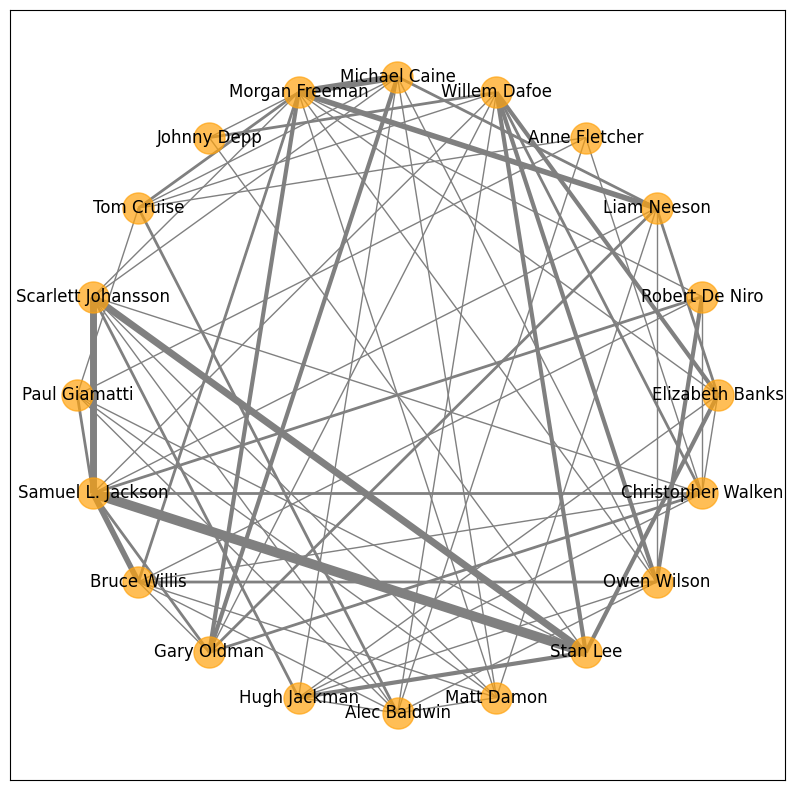

In [ ]:
# Subgraph with the nodes of highest degree
degree_sequence = sorted([(d, n) for n, d in G_actor.degree()], reverse=True)
high_degree_nodes = [n for d, n in degree_sequence[:20]]
H_actor = G_actor.subgraph(high_degree_nodes)

# Layout
pos = nx.shell_layout(H_actor)

plt.figure(figsize=(10, 10))
# nx.draw(H_actor, pos, with_labels=True, node_color=colors[2], node_size=500, edge_color='gray')
# plt.show()
nx.draw_networkx_nodes(H_actor, pos, node_color=colors[2], node_size=500, alpha=0.7)
weights = [H_actor[u][v]['weight'] for u, v in H_actor.edges()]
nx.draw_networkx_edges(H_actor, pos, width=weights, edge_color='gray')

# Draw the edge labels representing the weight
# edge_labels = {(u, v): d['weight'] for u, v, d in H_actor.edges(data=True)}
# nx.draw_networkx_edge_labels(H_actor, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(H_actor, pos)
plt.show()


In [ ]:
# Number of nodes
num_nodes = G_largest.number_of_nodes()

# Number of edges
num_edges = G_largest.number_of_edges()

print(f"The network has {num_nodes} nodes and {num_edges} edges.")


The network has 53528 nodes and 1994083 edges.


![image.png](attachment:image.png)

## **Detecting communities using the Girvan-Newman algorithm**

In [ ]:
# communities = girvan_newman(G_largest)
# top_level_communities = next(communities)
# community_lists = [list(community) for community in top_level_communities]

# # Print communities
# for i, community in enumerate(community_lists):
#     print(f"Community {i+1}: {community}")

# # This takes too long (Over 10 minutes)

In [ ]:
# Make smaller sample of G_largest
node_degrees = dict(G_largest.degree())
sorted_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)
N = 1000
top_nodes = sorted_nodes[:N]
G_largest_small = G_largest.subgraph(top_nodes)


In [ ]:
communities = girvan_newman(G_largest_small)
top_level_communities = next(communities)
community_lists = [list(community) for community in top_level_communities]

# Print communities
for i, community in enumerate(community_lists):
    print(f"Community {i+1}: {community}")

# N=1000 -> Approx 18-19 minutes

Community 1: ['Lois Maxwell', 'Laurence Fishburne', 'Apollo Bacala', 'Paul Dooley', 'Jake Gyllenhaal', 'Sam Shepard', 'William Hurt', 'Andy Serkis', 'Michael Kenneth Williams', 'Joe Pesci', 'Ray Garvey', 'Aaron Eckhart', 'Gregg Henry', 'Nathan Prevost', 'Mila Kunis', 'Deep Roy', 'Scott Lawrence', 'Jon Favreau', 'Dwayne Johnson', 'Dennis Haysbert', 'Sofía Vergara', 'Christopher Lee', 'Spencer Garrett', 'Natalie Portman', 'Sala Baker', 'James DuMont', 'Lucas Till', 'Ethan Suplee', 'Chris Evans', 'Toni Wynne', 'Dennis Quaid', 'Seann William Scott', 'Adewale Akinnuoye-Agbaje', 'Mark Ruffalo', 'Norman Reedus', 'Denzel Washington', 'Frank Adonis', 'Cuba Gooding Jr.', 'Nicole Kidman', 'Ving Rhames', 'Frances McDormand', 'Jonathan Loughran', 'Leonardo DiCaprio', 'Chris Rock', 'Geraldine James', 'Anthony Mackie', 'Miriam Margolyes', 'Karl Urban', 'Timothy Spall', 'Jeffrey Wright', 'Gary Sinise', 'David Strathairn', 'Ewen Bremner', 'Ewan McGregor', 'Isiah Whitlock Jr.', 'Ryan Gosling', 'Brian Co

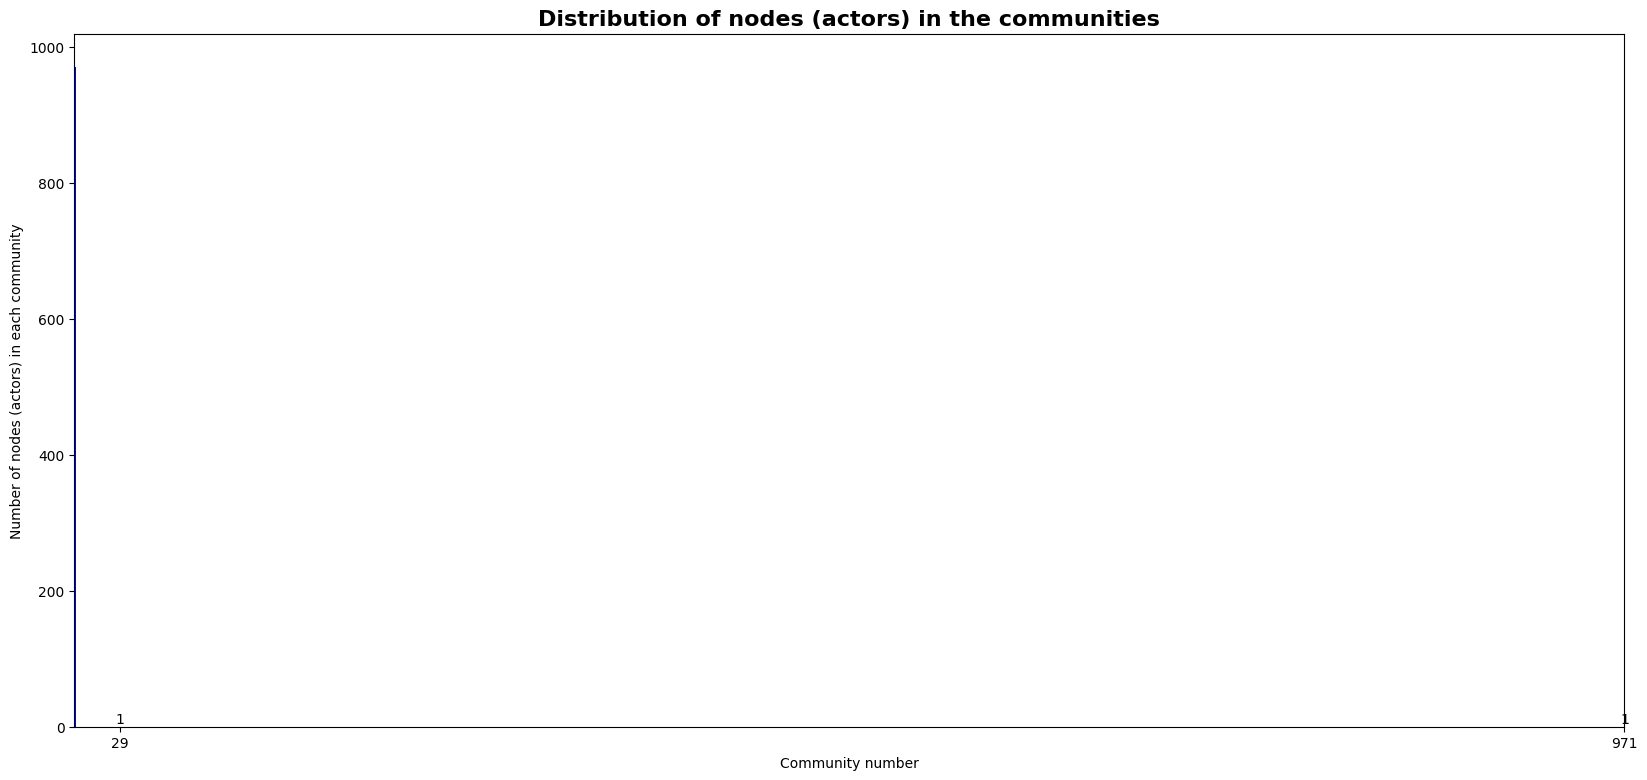

In [ ]:
community_sizes = [len(community) for community in community_lists]
community_count = pd.Series(community_sizes).value_counts()

# Plot
plt.figure(figsize=(20, 9))
plt.bar(community_count.values, community_count.index, color='blue', align='center')
for index, value in zip(community_count.index, community_count.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.ylabel('Number of nodes (actors) in each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (actors) in the communities', fontsize=16, fontweight="bold")
plt.xticks(community_count.index)

plt.show()


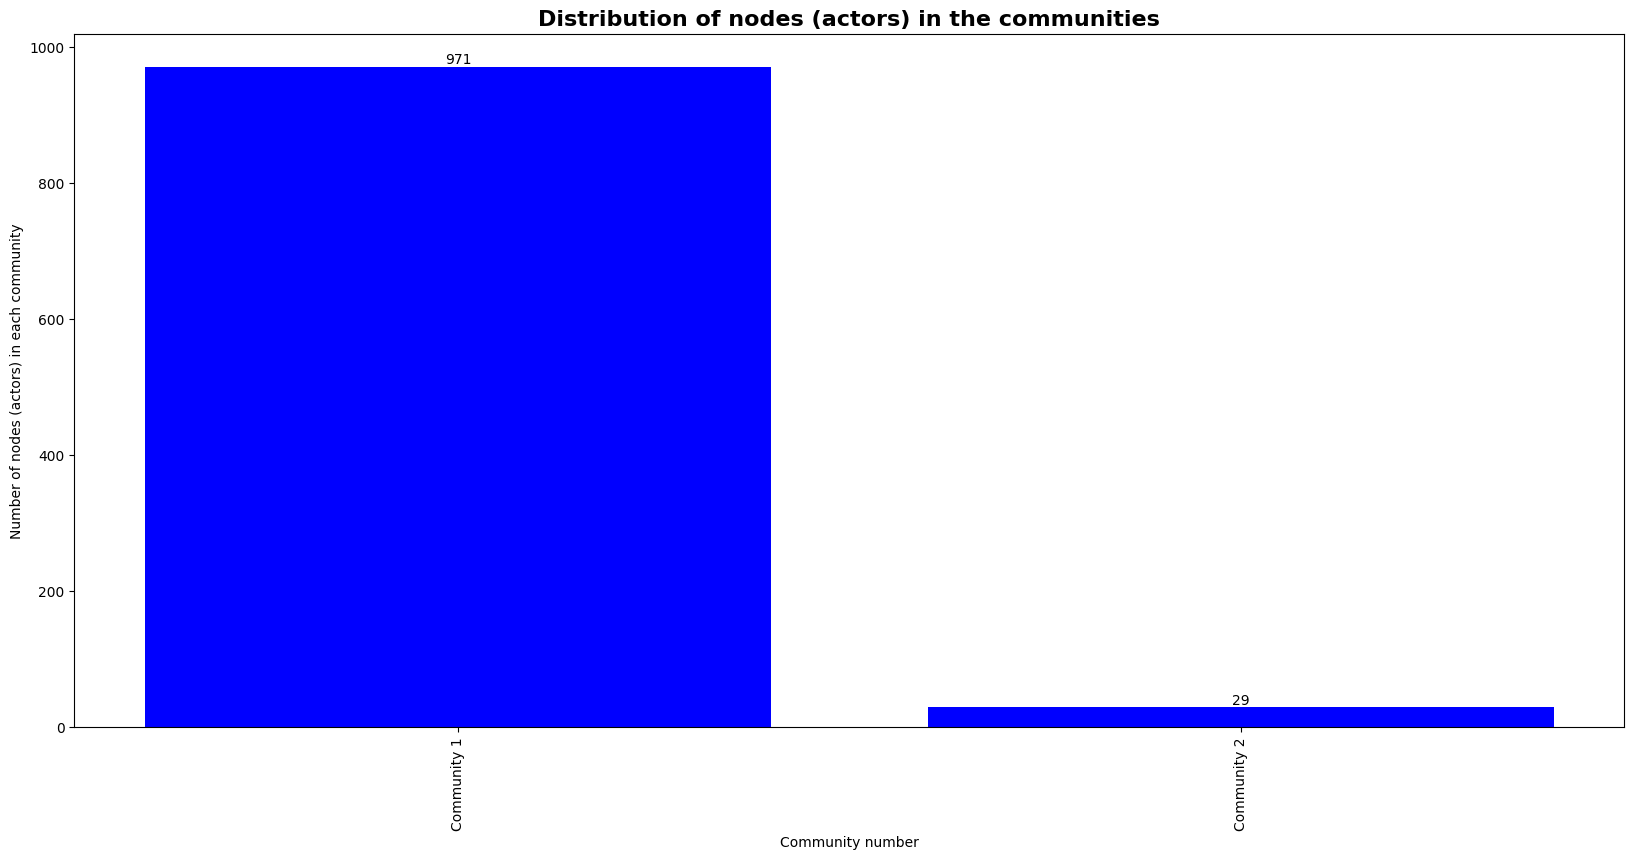

In [ ]:
community_sizes = [len(community) for community in community_lists]
df_community_sizes = pd.DataFrame(community_sizes, columns=['Size'], index=[f'Community {i+1}' for i in range(len(community_sizes))])
df_community_sizes = df_community_sizes.sort_index()

# Plot the distribution of community sizes
plt.figure(figsize=(20, 9))
plt.bar(df_community_sizes.index, df_community_sizes['Size'], color='blue', align='center')
for index, row in df_community_sizes.iterrows():
    plt.text(index, row['Size'] + 0.1, str(row['Size']), ha='center', va='bottom')

plt.ylabel('Number of nodes (actors) in each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (actors) in the communities', fontsize=16, fontweight="bold")
plt.xticks(rotation=90)

plt.show()


## **Betweenness centrality**

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G_largest_small)
print("Done1")
sorted_actors = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

# Print the top 10 actors
for i, actor in enumerate(sorted_actors[:10]):
    print(f"{i+1}. {actor} (Betweenness Centrality: {betweenness_centrality[actor]})")

# Approx 2:30 minutes

Done1
1. Tom Quinn (Betweenness Centrality: 0.025150951664362854)
2. Samuel L. Jackson (Betweenness Centrality: 0.011552764367262434)
3. Dub Taylor (Betweenness Centrality: 0.00804038613061984)
4. Morgan Freeman (Betweenness Centrality: 0.00797077319001199)
5. Matt Damon (Betweenness Centrality: 0.00634227135978361)
6. Stanley Tucci (Betweenness Centrality: 0.006014724622633362)
7. Paul Giamatti (Betweenness Centrality: 0.005798461235946511)
8. Alec Baldwin (Betweenness Centrality: 0.005730772334157464)
9. Channing Tatum (Betweenness Centrality: 0.005299260432415293)
10. Liam Neeson (Betweenness Centrality: 0.005287192411629661)


---
# **Movie similarity network**
---
- Nodes: Movies
- Edge: Weighted based on how many common actors there are in the corresponding movies.

In [ ]:
# Create Movie Similarity Network
G_movie = nx.Graph()
for i, row in credits.iterrows():
    G_movie.add_node(row['title'])
    for actor in credits_cast[i]:
        for movie in G_actor[actor['name']]:
            if movie != row['title']:
                if G_movie.has_edge(row['title'], movie):
                    G_movie[row['title']][movie]['weight'] += 1
                else:
                    G_movie.add_edge(row['title'], movie, weight=1)

print("G_movie done")
# Approx 2 minutes

G_movie done


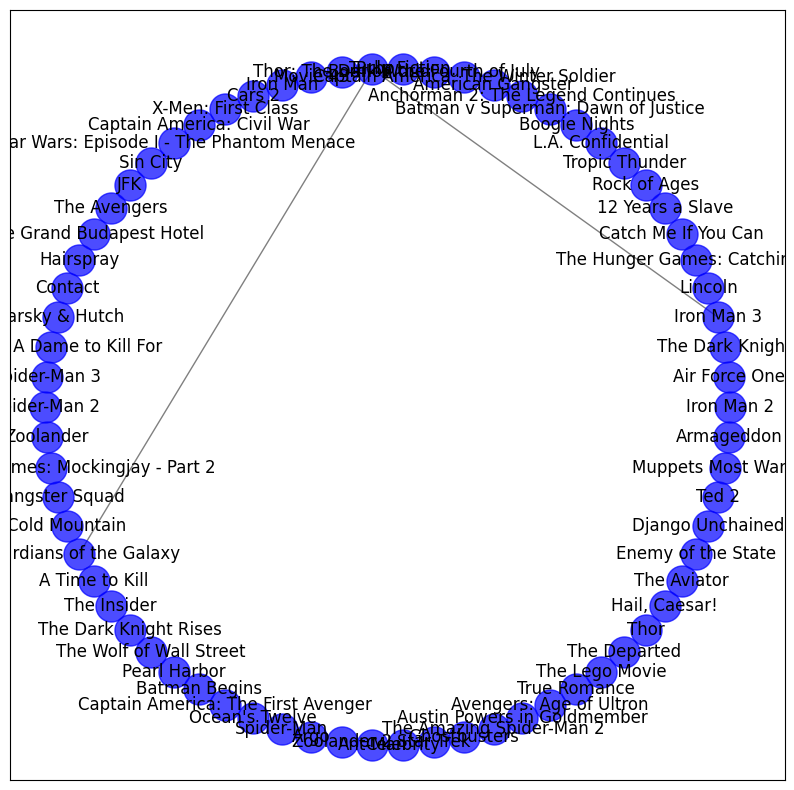

In [ ]:
# Largest connected component of the graph
largest_cc_movie = max(nx.connected_components(G_movie), key=len)

# Create a subgraph of G_movie with only the nodes in the largest connected component
G_largest_movie = G_movie.subgraph(largest_cc_movie)

# Subgraph with the nodes of highest degree
degree_sequence_movie = sorted([(d, n) for n, d in G_largest_movie.degree()], reverse=True)
high_degree_nodes_movie = [n for d, n in degree_sequence_movie[:70]]
H_movie = G_largest_movie.subgraph(high_degree_nodes_movie)

# Layout
pos_movie = nx.shell_layout(H_movie)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(H_movie, pos_movie, node_color='blue', node_size=500, alpha=0.7)
weights_movie = [H_movie[u][v]['weight'] for u, v in H_movie.edges()]
nx.draw_networkx_edges(H_movie, pos_movie, width=weights_movie, edge_color='gray')
nx.draw_networkx_labels(H_movie, pos_movie)
plt.show()

In [ ]:
# Number of nodes
num_nodes_movie = G_largest_movie.number_of_nodes()

# Number of edges
num_edges_movie = G_largest_movie.number_of_edges()

print(f"The network has {num_nodes_movie} nodes and {num_edges_movie} edges.")

The network has 58188 nodes and 12285355 edges.


In [ ]:
# Make smaller sample of G_largest_movie
node_degrees_movie = dict(G_largest_movie.degree())
sorted_nodes_movie = sorted(node_degrees_movie, key=node_degrees_movie.get, reverse=True)
N_movie = 1000
top_nodes_movie = sorted_nodes_movie[:N_movie]
G_largest_small_movie = G_largest_movie.subgraph(top_nodes_movie)

In [ ]:
# Apply Girvan-Newman algorithm
communities_movie = girvan_newman(G_largest_small_movie)
top_level_communities_movie = next(communities_movie)
community_lists_movie = [list(community) for community in top_level_communities_movie]

# Print communities
for i, community in enumerate(community_lists_movie):
    print(f"Community {i+1}: {community}")

Community 1: ['Se7en', 'The Bourne Legacy', 'The Dark Knight Rises', 'The Hunger Games', 'Zoolander 2', 'Hulk', 'Masked and Anonymous', 'Anchorman: The Legend of Ron Burgundy', 'Lucky Number Slevin', 'The Shadow', 'Idiocracy', 'Over the Hedge', 'Lincoln', 'Stop-Loss', 'The Black Dahlia', 'Movie 43', "Brooklyn's Finest", 'Factory Girl', 'Exodus: Gods and Kings', 'Philadelphia', 'The Royal Tenenbaums', 'Ronin', 'The Golden Compass', 'Jumper', 'W.', 'Captain America: The First Avenger', 'Margin Call', 'Austin Powers: The Spy Who Shagged Me', 'The Young Victoria', 'Public Enemies', 'Patriot Games', 'Yoga Hosers', 'Big Hero 6', 'Taken 3', 'The Angry Birds Movie', 'Duplex', 'O Brother, Where Art Thou?', 'The Core', 'Machete', 'The Ridiculous 6', 'Grindhouse', 'Dr. Dolittle 2', 'We Were Soldiers', 'Miracle at St. Anna', 'Brokeback Mountain', 'Night at the Museum: Secret of the Tomb', 'I Heart Huckabees', 'Jack the Giant Slayer', 'The Break-Up', 'Monsters University', 'Apollo 13', 'The Cotton 

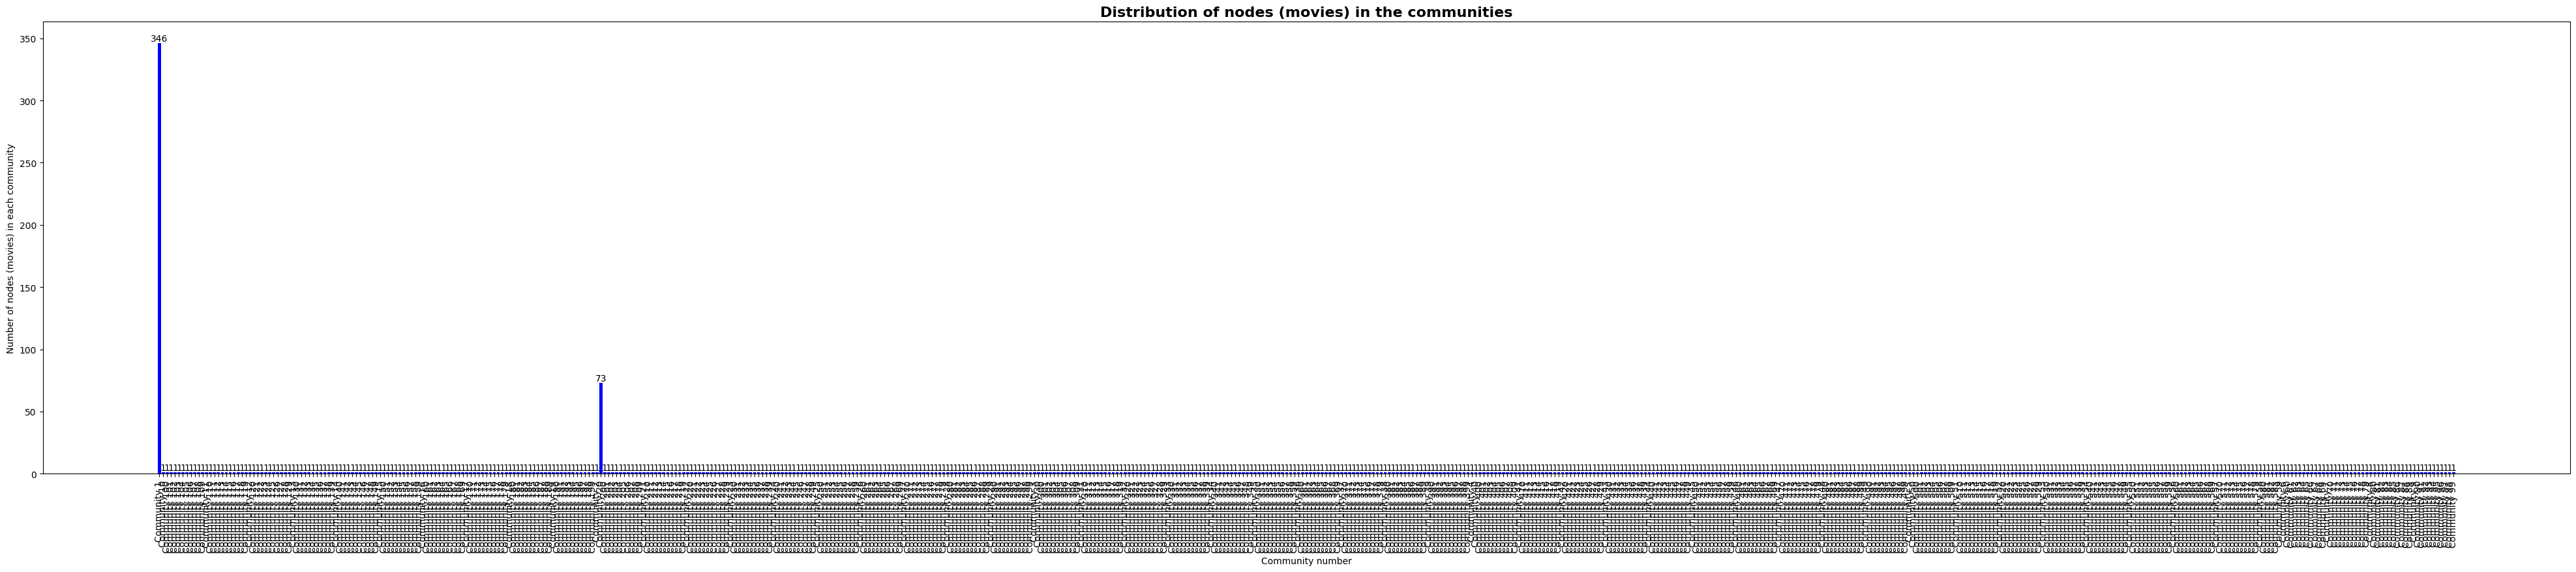

In [ ]:
# Plot the distribution of community sizes
community_sizes_movie = [len(community) for community in community_lists_movie]
df_community_sizes_movie = pd.DataFrame(community_sizes_movie, columns=['Size'], index=[f'Community {i+1}' for i in range(len(community_sizes_movie))])
df_community_sizes_movie = df_community_sizes_movie.sort_index()

plt.figure(figsize=(50, 9))
plt.bar(df_community_sizes_movie.index, df_community_sizes_movie['Size'], color='blue', align='center')
for index, row in df_community_sizes_movie.iterrows():
    plt.text(index, row['Size'] + 0.1, str(row['Size']), ha='center', va='bottom')

plt.ylabel('Number of nodes (movies) in each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (movies) in the communities', fontsize=16, fontweight="bold")
plt.xticks(rotation=90)

plt.show()

In [ ]:
betweenness_centrality_movie = nx.betweenness_centrality(G_largest_small_movie)
print("Done1")
sorted_actors = sorted(betweenness_centrality_movie, key=betweenness_centrality_movie.get, reverse=True)

# Print the top 10 actors
for i, movie in enumerate(sorted_actors[:10]):
    print(f"{i+1}. {movie} (Betweenness Centrality: {betweenness_centrality_movie[movie]})")

# Approx 4 minutes

Done1
1. John Carter (Betweenness Centrality: 0.08259871645663737)
2. Scarface (Betweenness Centrality: 0.05346983692627732)
3. Wyatt Earp (Betweenness Centrality: 0.053277873747789764)
4. Jackie Brown (Betweenness Centrality: 0.04692213109877851)
5. Beetlejuice (Betweenness Centrality: 0.03575498617281521)
6. Turbo (Betweenness Centrality: 0.031303702371764344)
7. Easy A (Betweenness Centrality: 0.006056049789133681)
8. Spider-Man 3 (Betweenness Centrality: 0.0045380157548689315)
9. Shutter Island (Betweenness Centrality: 0.0031462260364509267)
10. The Hunger Games: Catching Fire (Betweenness Centrality: 0.00299288543540551)


## **Using the Louvain algorithm to find communities**

In [ ]:
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

# Assuming 'G' is your network
communities_louvain_method = community_louvain.best_partition(G_largest_small_movie)

# Visualize the communities
# pos = nx.spring_layout(G_largest_small_movie)
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G_largest_small_movie, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G_largest_small_movie, pos, alpha=0.5)
# plt.show()


In [ ]:
print('The algorithm found', len(np.unique(list(communities_louvain_method.values()))), 'communities in total')

The algorithm found 587 communities in total


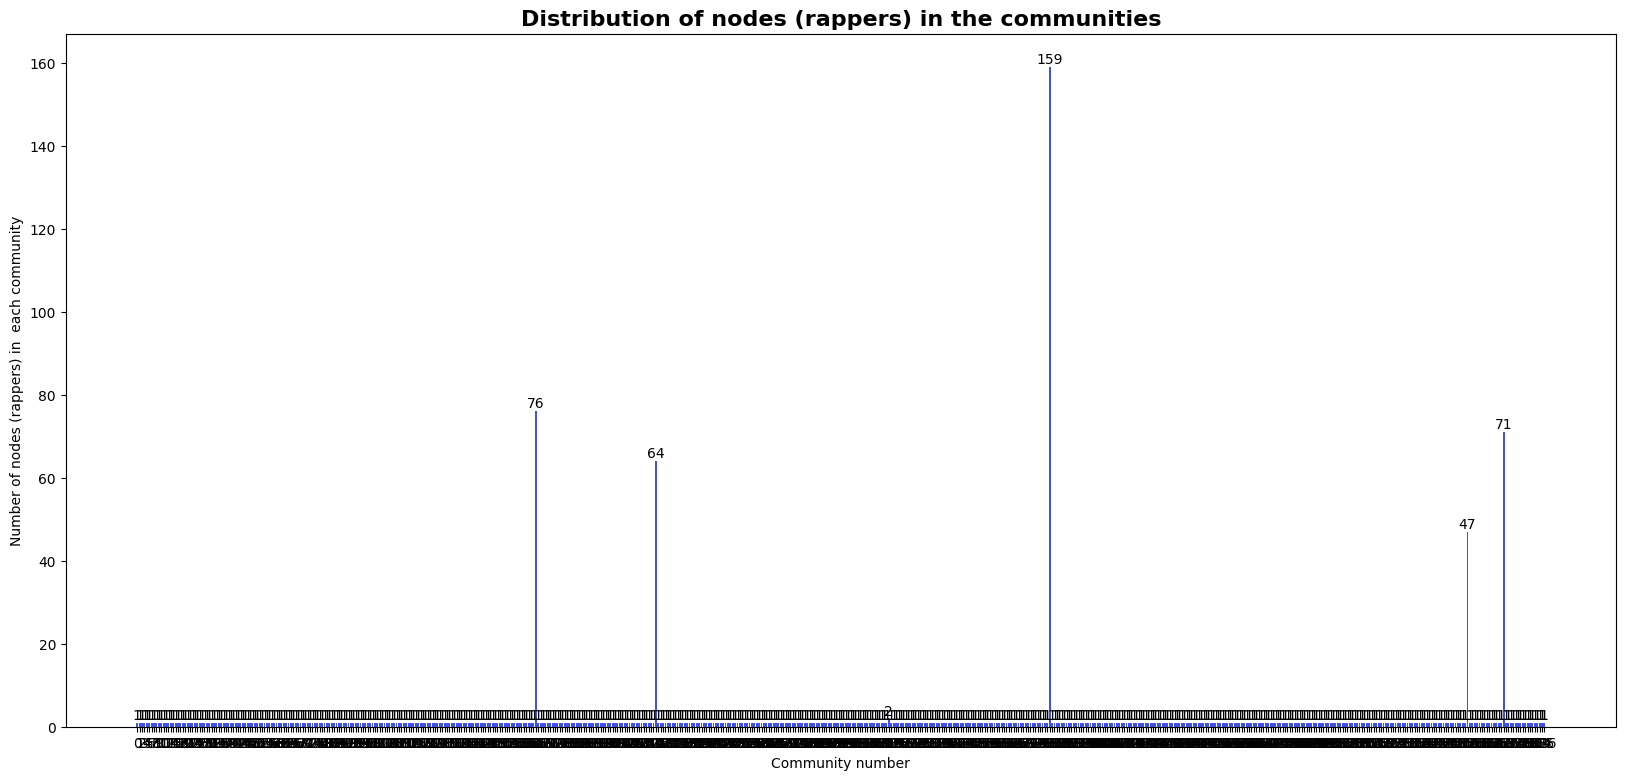

In [ ]:
# Count number of rappers in each comunity
community_louvain_count = pd.Series(list(communities_louvain_method.values())).value_counts()

# Plot
plt.figure(figsize = (20,9))
plt.bar(community_louvain_count.index, community_louvain_count.values, color=d_color, align='center')
# Count the nodes in community
for index, value in zip(community_louvain_count.index, community_louvain_count.values):
    plt.text(index, value+0.1, str(value), ha='center', va='bottom')

    
plt.ylabel('Number of nodes (rappers) in  each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (rappers) in the communities', fontsize=16, fontweight="bold")
plt.xticks(community_louvain_count.index)

plt.show()